### Original example: https://datascienceplus.com/time-dependent-roc-for-survival-prediction-models-in-r/

In [2]:
library(survival)
require(dplyr)
library(psych)
require(ggplot2)
require(survminer)
library(data.table)
require(EnvStats)
library(openxlsx)
library(pROC)

In [4]:
library(repr)

In [5]:
df.basic <- read.xlsx("./01_TimeDependentROC.xlsx", sheet = 1, startRow = 1, colNames = TRUE)

In [6]:
head(df.basic)

,var2,event,day
,<dbl>,<dbl>,<dbl>
1,1.4426617,1,368
2,0.7040365,0,2001
3,0.1777018,1,546
4,0.1343007,0,2172
5,0.2474800,0,869
6,0.2190516,1,1093


# Step 1:전체 대상자의 event 커브를 그려본다

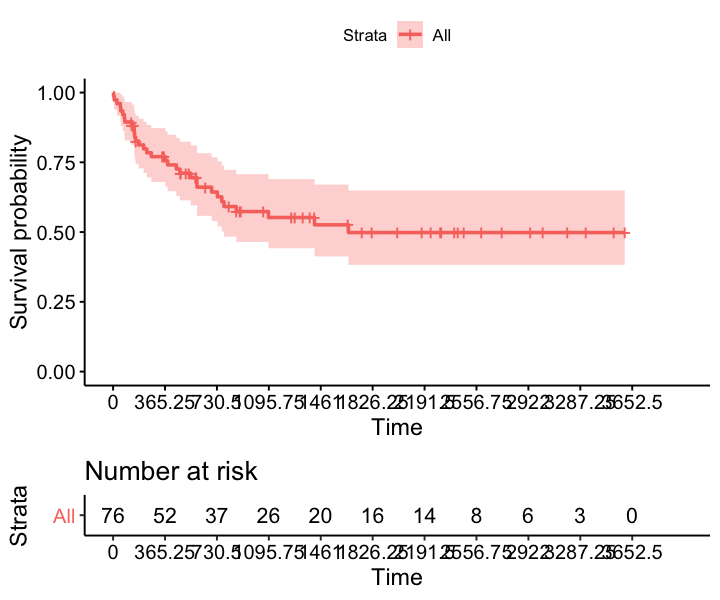

In [8]:
options(repr.plot.width=6, repr.plot.height=5)
surv_obj <- with(df.basic, Surv(day,event==1))
ggsurvplot(survfit(surv_obj ~ 1,
                   data = df.basic),
           risk.table = TRUE,
           break.time.by = 365.25) # 365.25 가 1년이다

# Step 2: var2 변수가 event 에 유의한 변수 인지 확인

### 아래 결과 p = 0.005 로 유의한 변수임을 우선 확인할 수 있다

In [9]:
surv_obj <- with(df.basic, Surv(day,event==1))
surv_cox <- coxph(surv_obj~ var2,data=df.basic)
summary(surv_cox)

Call:
coxph(formula = surv_obj ~ var2, data = df.basic)

  n= 76, number of events= 32 

        coef exp(coef) se(coef)     z Pr(>|z|)    
var2 0.30675   1.35900  0.09298 3.299  0.00097 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     exp(coef) exp(-coef) lower .95 upper .95
var2     1.359     0.7358     1.133     1.631

Concordance= 0.739  (se = 0.04 )
Likelihood ratio test= 7.98  on 1 df,   p=0.005
Wald test            = 10.88  on 1 df,   p=0.001
Score (logrank) test = 12.4  on 1 df,   p=4e-04


# Step 3: Time dependent ROC curve 그리기

### Stime / status / marker 를 정한다. 
### span은 method가 NNE 일때 필요한 변수이며,
### Kaplan Meier (KM)이 좀더 익숙한 이름이라, 변경해봄

In [10]:
library(survivalROC)
## Define a helper functio nto evaluate at various t
survivalROC_helper <- function(t) {
    survivalROC(Stime        = df.basic$day,
                status       = (df.basic$event == 1),
                marker       = df.basic$var2,
                predict.time = t,
                method       = "KM") #NNE
                #span = 0.25 * nrow(df.basic)^(-0.20))
}

Warning message:
“package ‘survivalROC’ was built under R version 3.6.3”

### 아래의 예제는 기간(t)만 변경했다

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(df_survivalROC)`”

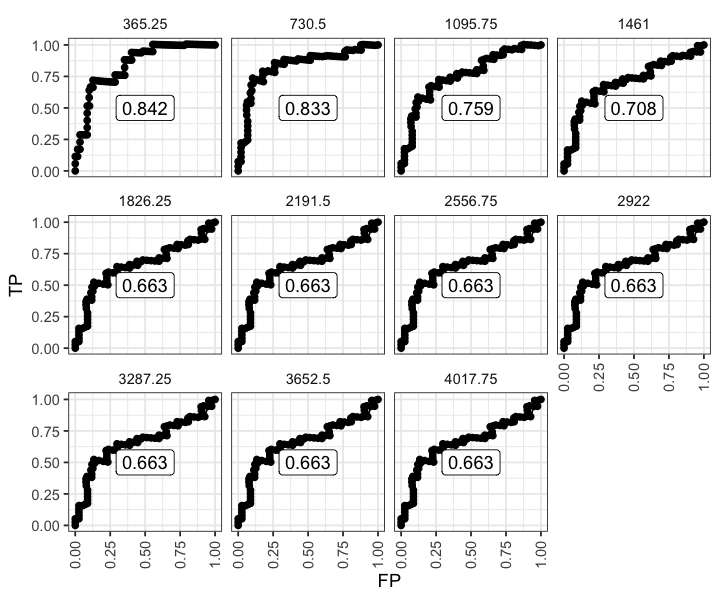

In [12]:
library(tidyverse)
## Evaluate every 180 days
survivalROC_data <- data_frame(t = 365.25 * c(1,2,3,4,5,6,7,8,9,10,11)) %>%
    mutate(survivalROC = map(t, survivalROC_helper),
           ## Extract scalar AUC
           auc = map_dbl(survivalROC, magrittr::extract2, "AUC"),
           ## Put cut off dependent values in a data_frame
           df_survivalROC = map(survivalROC, function(obj) {
               as_data_frame(obj[c("cut.values","TP","FP")])
           })) %>%
    dplyr::select(-survivalROC) %>%
    unnest() %>%
    arrange(t, FP, TP)
## Plot
survivalROC_data %>%
    ggplot(mapping = aes(x = FP, y = TP)) +
    geom_point() +
    geom_line() +
    geom_label(data = survivalROC_data %>% dplyr::select(t,auc) %>% unique,
               mapping = aes(label = sprintf("%.3f", auc)), x = 0.5, y = 0.5) +
    facet_wrap( ~ t) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5),
          legend.key = element_blank(),
          plot.title = element_text(hjust = 0.5),
          strip.background = element_blank())

# Step 4: (테스트) 1년째 (t=365.25)에서 1-TP+FP를 최소화시키는 위치를 찾음 (TP + (1-FP)의 최대화와 동일)

In [13]:
time = 365.25
index = with(survivalROC_data %>% filter(t == time), which.min(1-TP+ FP))
# 동일한 결과 with(survivalROC_data %>% filter(t == time), which.max(TP+1-FP))
index

[1] 21

### 결과를 보니, cut off가 1.0373

In [14]:
(survivalROC_data %>% filter(t == 365.25))[index,]

t,auc,cut.values,TP,FP
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
365.25,0.8419898,1.0373,0.7200536,0.1268952


# Step 5: 5년째 부터는 모두 AUC가 0.690, 그래서 일단 5년 event rate을 보자

In [15]:
time = 365.25 * 5
index = with(survivalROC_data %>% filter(t == time), which.min(1-TP+ FP))
index

[1] 25

In [16]:
(survivalROC_data %>% filter(t == time))[index,]

t,auc,cut.values,TP,FP
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1826.25,0.6626156,0.7290579,0.5232509,0.1332826


### Cut-off가 0.7290579로 나온다

# Step 6: 이 기준으로 그룹을 지어보자

In [17]:
df.basic$group = ifelse(df.basic$var2 >= 0.7290579, "Over","Under")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”

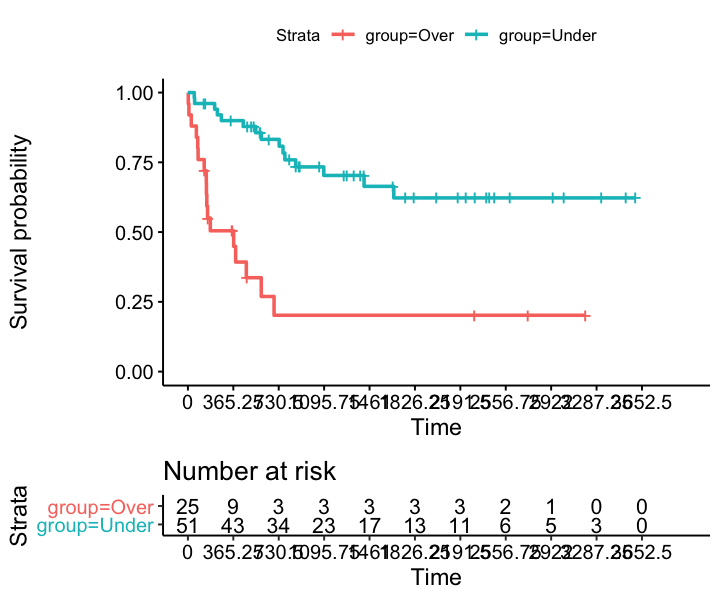

In [18]:
ggsurvplot(survfit(surv_obj ~ group,
                   data = df.basic),
           risk.table = TRUE,
           break.time.by = 365.25)